In [1]:
from shapely.geometry import Polygon,LineString,box,MultiPolygon, GeometryCollection
from shapely.ops import unary_union, split
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection

a = Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])
b = Polygon([(1, 0), (2, 0), (2, 1), (0, 1)])
a.union(b)
c=a.union(b)
print(c)


POLYGON ((0 0, 0 1, 1 1, 2 1, 2 0, 1 0, 0 0))


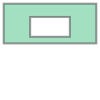

In [2]:
p1=Polygon([(0, 0), (1, 0), (1, 3), (0, 3)])
p2=Polygon([(1, 0), (2, 0), (2, 1), (1, 1)])
p3=Polygon([(1, 1), (2, 1), (2, 3), (1, 3)])
p4=Polygon([(2, 0), (3, 0), (3, 0.5), (2, 0.5)])
p5=Polygon([(3, 0), (5, 0), (5, 0.5), (3, 0.5)])
p6=Polygon([(2, 2), (5, 2), (5, 2.5), (2, 2.5)])
p7=Polygon([(2, 2.5), (5, 2.5), (5, 3), (2, 3)])
p8=Polygon([(5, 0), (7, 0), (7, 1.5), (5, 1.5)])
p9=Polygon([(5, 1.5), (7, 1.5), (7, 3), (5, 3)])

poligonos=[p1,p2,p3,p4,p5,p6,p7,p8,p9]
pu=unary_union(poligonos) #Unión de todos los polygonos
pu



In [3]:
from shapely.geometry import (
    Polygon, MultiPolygon, GeometryCollection, box, LineString
)
from shapely.ops import split

def split_rectangles(geom, *, usar_split=False, tol=1e-8):
    """
    Divide un Polygon/MultiPolygon/GeometryCollection en rectángulos
    verticales sin agujeros.  Devuelve una lista de Polygon.
    """
    # ---------- despachador por tipo ----------
    if geom.is_empty:
        return []
    if isinstance(geom, Polygon):
        return _split_polygon(geom, usar_split, tol)
    if isinstance(geom, (MultiPolygon, GeometryCollection)):
        out = []
        for g in geom.geoms:                # procesa cada sub-geometría
            out.extend(split_rectangles(g, usar_split=usar_split, tol=tol))
        return out
    # Ignora puntos, líneas, etc.
    
    return []

# ---------- lógica para un solo Polygon ----------
def _split_polygon(poly: Polygon, usar_split: bool, tol: float):
    """
    Parte *cualquier* polígono orto-alineado (con o sin huecos) en
    rectángulos verticales sin perforaciones.
    """
    # 1)  Coordenadas X donde cortar
    xs = {x for x, _ in poly.exterior.coords}          # TODOS los vértices
    for ring in poly.interiors:                        # …y los de cada agujero
        xs.update(x for x, _ in ring.coords)
    xs = sorted(xs)

    # 2)  Rebanar con tiras o con split()
    minx, miny, maxx, maxy = poly.bounds
    partes = [poly] if usar_split else []
    if usar_split:
        # --- variante split() ----------------------------------------------
        for x in xs[1:-1]:                             # evita extremos
            cutter = LineString([(x, miny - tol), (x, maxy + tol)])
            nuevas = []
            for p in partes:
                nuevas.extend(split(p, cutter))
            partes = nuevas
    else:
        # --- variante tiras + intersection() -------------------------------
        for x0, x1 in zip(xs[:-1], xs[1:]):
            tira = box(x0, miny, x1, maxy)
            corte = poly.intersection(tira)
            if not corte.is_empty:
                partes.append(corte)

    # 3)  Aplanar todo y devolver sólo Polygon sin huecos
    rects = []
    for g in partes:
        if g.geom_type == "Polygon":
            rects.append(g)
        else:  # MultiPolygon o GeometryCollection
            rects.extend(
                p for p in g.geoms if p.geom_type == "Polygon"
            )

    # 4)  Filtra por si quedara algún hueco (no debería, pero por seguridad)
    return [r for r in rects if not r.interiors]

def simplificar_rectangulos(rects, tol=1e-8):
    """
    Simplifica una lista de rectángulos (Polygon) a su forma más simple.
    Devuelve una lista de Polygon.
    """
    # 1 · simplificar cada rectángulo
    simplificados = [r.envelope for r in rects]

    # 2 · eliminar duplicados y vacíos
    simplificados = set(simplificados)
    simplificados = [r for r in simplificados if not r.is_empty]

    # 3 · devolver
    return list(simplificados)

def merge_horizontal(rects, tol=1e-9):
    """
    Agrupa rectángulos contiguos que tengan exactamente el mismo (miny, maxy).
    Devuelve una lista nueva, sin modificar la original.
    """
    # ➊ agrupa por altura (miny, maxy)
    from collections import defaultdict
    grupos = defaultdict(list)
    for r in rects:
        minx, miny, maxx, maxy = r.bounds
        grupos[(round(miny, 9), round(maxy, 9))].append((minx, maxx, r))

    fusionados = []
    for (miny, maxy), lst in grupos.items():
        # ➋ ordena por minx y recorre fusionando si los bordes se tocan
        lst.sort(key=lambda t: t[0])            # por minx
        cur_minx, cur_maxx, _ = lst[0]
        for minx, maxx, _ in lst[1:]:
            if abs(minx - cur_maxx) <= tol:     # se tocan → extiende
                cur_maxx = maxx
            else:                              # hueco → cierra rect. actual
                fusionados.append(
                    box(cur_minx, miny, cur_maxx, maxy)
                )
                cur_minx, cur_maxx = minx, maxx
        # ➌ último de la fila
        fusionados.append(box(cur_minx, miny, cur_maxx, maxy))

    return fusionados

def plot_rectangles(rects, *, alpha=0.6, edgecolor="black",
                    title="Rectángulos finales"):
    """
    Dibuja todos los rectángulos (Polygons) en una misma figura.
    """
    patches = [MplPolygon(list(r.exterior.coords), closed=True) for r in rects]

    fig, ax = plt.subplots(figsize=(7, 4))
    pcol = PatchCollection(
        patches,
        cmap=plt.cm.viridis,           # color por índice
        edgecolor=edgecolor,
        alpha=alpha
    )
    pcol.set_array(np.arange(len(patches)))  # colores automáticos
    ax.add_collection(pcol)

    ax.autoscale()
    ax.set_aspect("equal", adjustable="box")
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.grid(True, linestyle="--", linewidth=0.3)
    plt.show()

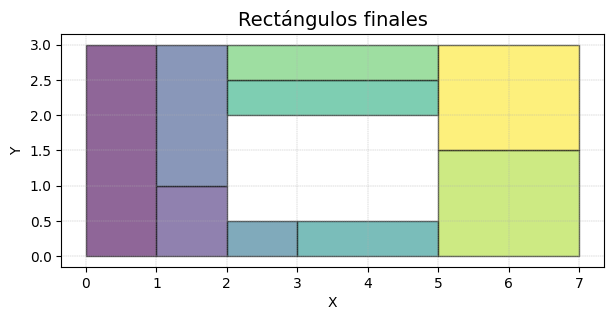

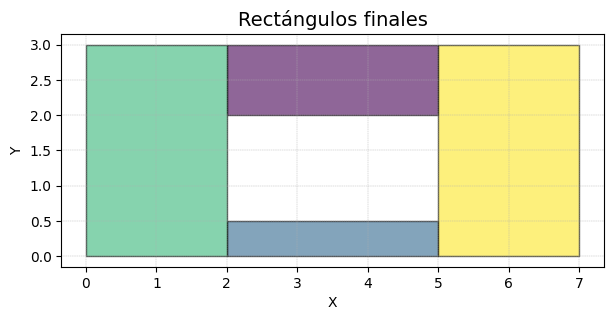

In [4]:

rects = split_rectangles(pu) # devuelve una lista de Polygon
rects_simplified = simplificar_rectangulos(rects)
rect_fusionados=merge_horizontal(rects_simplified)
plot_rectangles(poligonos)
plot_rectangles(rect_fusionados)


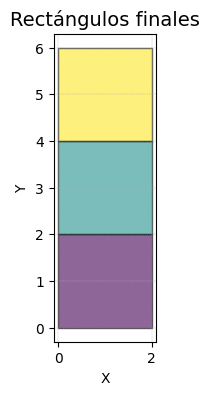

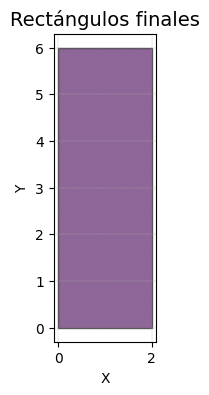

In [5]:
#ejemplos
ej1 = [
    Polygon([(0, 0), (2, 0), (2, 2), (0, 2)]),        # inferior
    Polygon([(0, 2), (2, 2), (2, 4), (0, 4)]),        # medio
    Polygon([(0, 4), (2, 4), (2, 6), (0, 6)])         # superior
]
pu=unary_union(ej1) #Unión de todos los polygonos
rects = split_rectangles(pu) # devuelve una lista de Polygon
rects_simplified = simplificar_rectangulos(rects) # devuelve una lista de Polygon
rect_fusionados=merge_horizontal(rects_simplified)
plot_rectangles(ej1)
plot_rectangles(rect_fusionados)

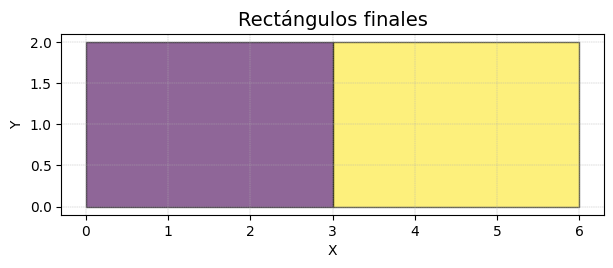

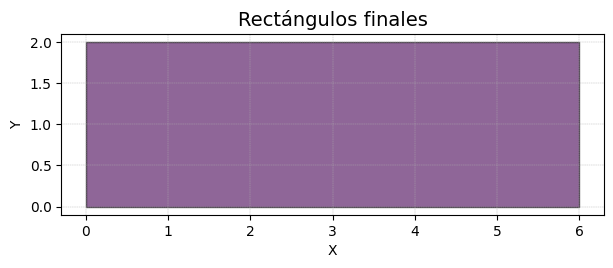

In [6]:
#ejemplos
ej2 = [
    Polygon([(0, 0), (3, 0), (3, 2), (0, 2)]),        # izquierdo
    Polygon([(3, 0), (6, 0), (6, 2), (3, 2)])         # derecho
]
pu=unary_union(ej2) #Unión de todos los polygonos
rects = split_rectangles(pu) # devuelve una lista de Polygon
rects_simplified = simplificar_rectangulos(rects) # devuelve una lista de Polygon
rect_fusionados=merge_horizontal(rects_simplified)
plot_rectangles(ej2)
plot_rectangles(rect_fusionados)

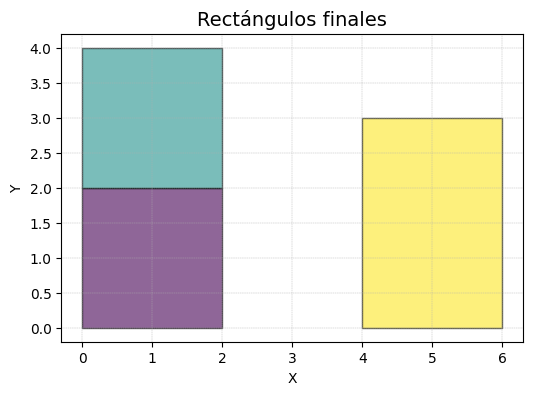

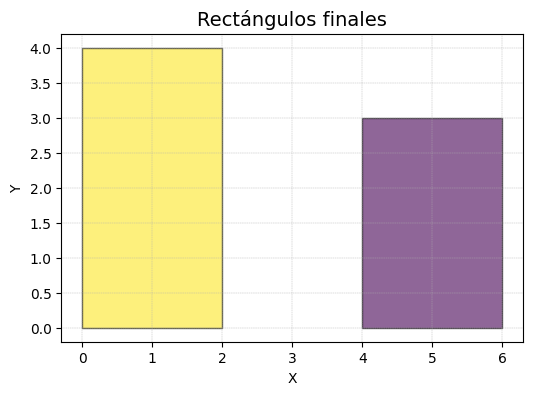

In [7]:
#ejemplos
ej3 = [
    Polygon([(0, 0), (2, 0), (2, 2), (0, 2)]),        # inferior (columna)
    Polygon([(0, 2), (2, 2), (2, 4), (0, 4)]),        # superior (columna)
    Polygon([(4, 0), (6, 0), (6, 3), (4, 3)])         # aislado
]

pu=unary_union(ej3) #Unión de todos los polygonos
rects = split_rectangles(pu) # devuelve una lista de Polygon
rects_simplified = simplificar_rectangulos(rects) # devuelve una lista de Polygon
rect_fusionados=merge_horizontal(rects_simplified)
plot_rectangles(ej3)
plot_rectangles(rect_fusionados)

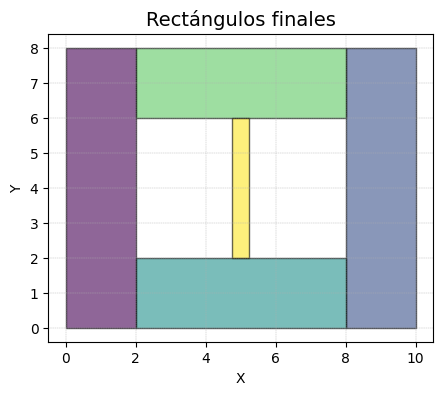

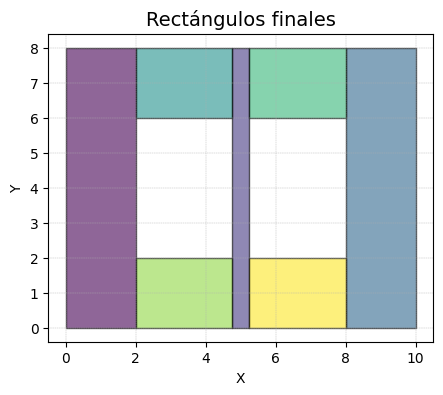

In [8]:
#ejemplos
frame_left   = Polygon([(0, 0), (2, 0), (2, 8), (0, 8)])
frame_right  = Polygon([(8, 0), (10, 0), (10, 8), (8, 8)])
frame_bottom = Polygon([(2, 0), (8, 0), (8, 2), (2, 2)])
frame_top    = Polygon([(2, 6), (8, 6), (8, 8), (2, 8)])
split_bar    = Polygon([(4.75, 2), (5.25, 2), (5.25, 6), (4.75, 6)])
ej4 = [frame_left, frame_right, frame_bottom, frame_top, split_bar]

pu=unary_union(ej4) #Unión de todos los polygonos
rects = split_rectangles(pu) # devuelve una lista de Polygon
rects_simplified = simplificar_rectangulos(rects) # devuelve una lista de Polygon
rect_fusionados=merge_horizontal(rects_simplified)
plot_rectangles(ej4)
plot_rectangles(rect_fusionados)

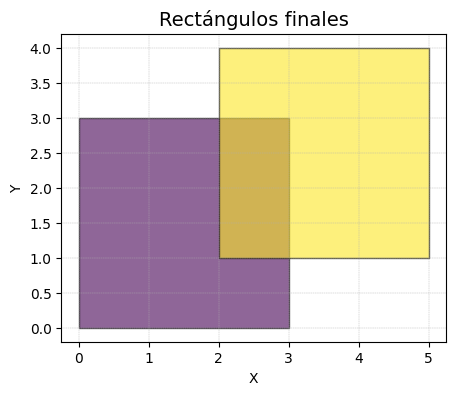

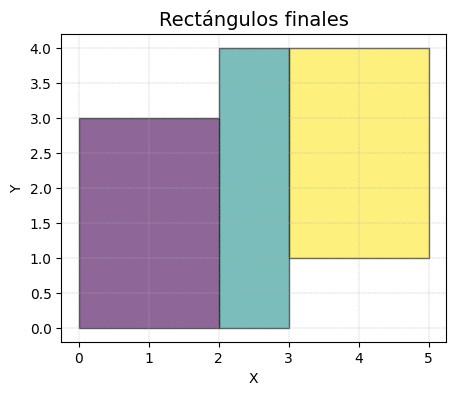

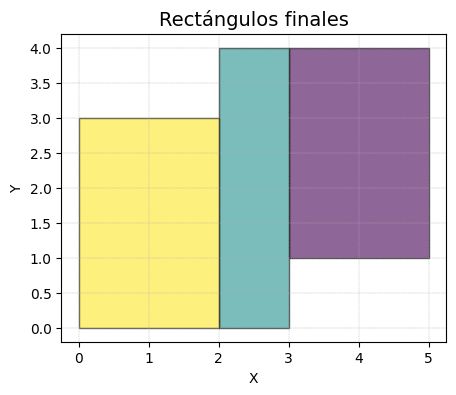

In [9]:
#ejemplos
ej5 = [
    Polygon([(0, 0), (3, 0), (3, 3), (0, 3)]),        # primero
    Polygon([(2, 1), (5, 1), (5, 4), (2, 4)])         # segundo (superpuesto)
]


pu=unary_union(ej5) #Unión de todos los polygonos
rects = split_rectangles(pu) # devuelve una lista de Polygon
rects_simplified = simplificar_rectangulos(rects) # devuelve una lista de Polygon
rect_fusionados=merge_horizontal(rects_simplified)
plot_rectangles(ej5)
plot_rectangles(rects)
plot_rectangles(rect_fusionados)

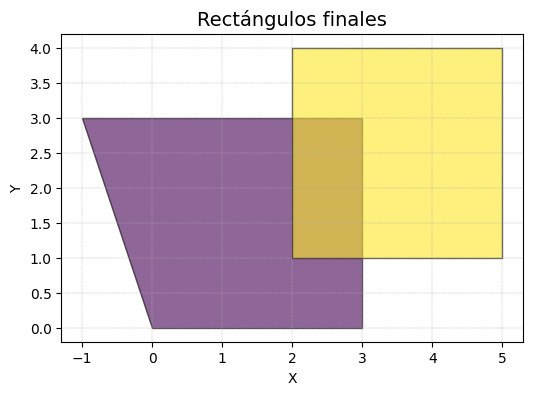

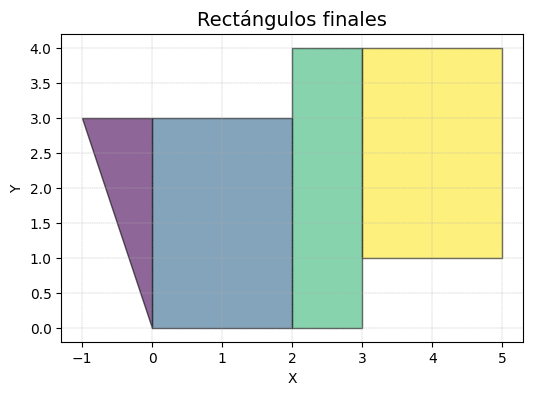

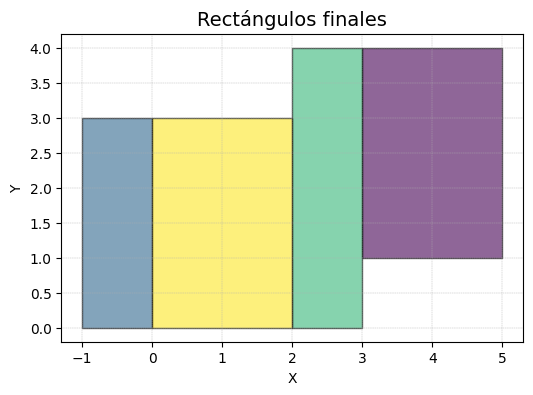

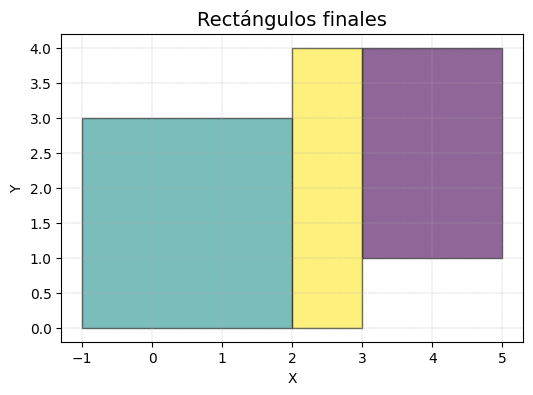

In [10]:
#ejemplos
ej6 = [
    Polygon([(0, 0), (3, 0), (3, 3), (-1, 3)]),        # primero
    Polygon([(2, 1), (5, 1), (5, 4), (2, 4)])         # segundo (superpuesto)
]


pu=unary_union(ej6) #Unión de todos los polygonos
rects = split_rectangles(pu) # devuelve una lista de Polygon
rects_simplified = simplificar_rectangulos(rects) # devuelve una lista de Polygon
rect_fusionados=merge_horizontal(rects_simplified)
plot_rectangles(ej6)
plot_rectangles(rects)
plot_rectangles(rects_simplified)
plot_rectangles(rect_fusionados)